In [5]:
import os
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from fastprogress.fastprogress import progress_bar
import hlda
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
basedir = '../'
sys.path.append(basedir)

import pylab as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from hlda.sampler import HierarchicalLDA
from ipywidgets import widgets
from IPython.core.display import HTML, display

import string
import glob
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
mails=pd.read_csv('/content/drive/MyDrive/Data_clean_processed.csv')
vocab=pd.read_csv('/content/drive/MyDrive/clean_vocab.csv')

In [7]:
all_docs=list(mails['bow'])
all_docs=all_docs[:10000]
new_docs=[]
for item in all_docs:
  item=item.replace('aaa','')
  item=item.replace('imagemasker','')
  item=item.replace('urlmasker','')
  new_docs.append(item)
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

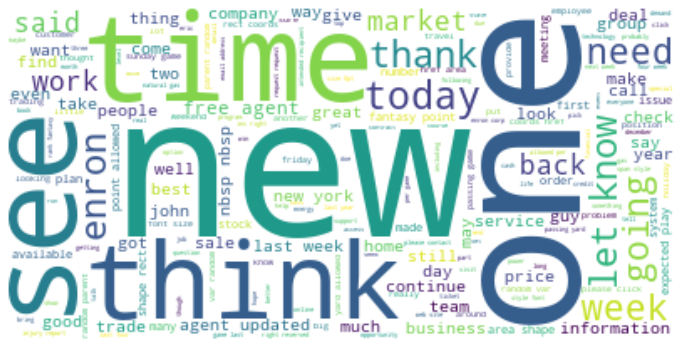

CPU times: user 4.58 s, sys: 219 ms, total: 4.8 s
Wall time: 4.85 s


In [8]:
%%time
wordcloud = WordCloud(background_color='white').generate(' '.join(new_docs))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [9]:
%%time
from string import digits
corpus = []
all_docs = []
vocab = set()

stemmer = PorterStemmer()
for item in new_docs:
      try:
          remove_digits = str.maketrans('', '', digits)
          item = item.translate(remove_digits)
          all_docs.append(item)  
          tokens = word_tokenize(str(item))
          filtered = []
          for w in tokens:
              w = stemmer.stem(w.lower()) # use Porter's stemmer
              if len(w) < 3:              # remove short tokens
                  continue
              if w in stopset:            # remove stop words
                  continue
              filtered.append(w)
              
          vocab.update(filtered)
          corpus.append(filtered)      
          
      except UnicodeDecodeError:
          print('hel')

CPU times: user 18.9 s, sys: 56.8 ms, total: 19 s
Wall time: 19.1 s


In [10]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

In [11]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [12]:
n_samples = 10      # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3       # the number of levels in the tree
display_topics = 5   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [13]:
%%time
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling

..... 5
topic=0 level=0 (documents=10000): get, pleas, time, know, enron, 
    topic=1 level=1 (documents=2279): com, enron, email, receiv, click, 
        topic=2 level=2 (documents=584): market, stock, news, compani, power, 
        topic=3 level=2 (documents=338): game, week, allow, yard, pass, 
        topic=6 level=2 (documents=938): com, request, pleas, mail, click, 
        topic=25 level=2 (documents=42): citi, content, aol, mime, proposit, 
        topic=32 level=2 (documents=126): week, play, start, practic, sore, 
        topic=34 level=2 (documents=9): hendersen, deer, dead, beagl, fat, 
        topic=44 level=2 (documents=13): like, dot, bilateraldeliverynotic, bledso, determin, 
        topic=47 level=2 (documents=10): admir, camil, rumour, thk, hang, 
        topic=71 level=2 (documents=11): terribl, yesterday, griffith, kayn, inherit, 
        topic=92 level=2 (documents=13): governor, stitl, sushi, bv_engineid, pappasito, 
        topic=98 lev

In [14]:
colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

def show_doc(d=0):
    
    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()   
    
    n_words = 10
    with_weights = False    
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n] 
        msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
        msg += node.get_top_words(n_words, with_weights)
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = corpus[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

In [15]:

widgets.interact(show_doc, d=(0, len(corpus)-1))
#435
#8122
#311

interactive(children=(IntSlider(value=0, description='d', max=9999), Output()), _dom_classes=('widget-interact…

<function __main__.show_doc(d=0)>

In [16]:
all_mails=list(mails['email_id'])[:10000]
all_mails[311]
# for i in range(len(all_docs)):
#   if 'footb' in all_docs[i]:
#     print(i)
# allen-p\deleted_items\354#1
#bass-e\deleted_items\225#1
#allen-p\deleted_items\115#1

'allen-p\\deleted_items\\115#1'

In [29]:
hp={}
hl={}
for i in range(len(hlda.document_leaves)):
  u=str(hlda.document_leaves[i]).split(' ')
  leaf=u[0].split('=')[1]
  parent=u[4].split('=')[1]
  if parent not in hp:
    hp[parent]=1
  else:
    hp[parent]+=1
  if leaf not in hl:
    hl[leaf]=1
  else:
    hl[leaf]+=1

In [49]:
import matplotlib.pyplot as plt
x=[]
y=[]
for k in hp:
  x.append(k)
  y.append(hp[k])


<BarContainer object of 19 artists>

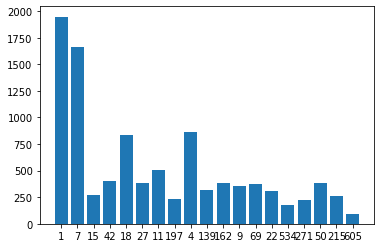

In [50]:
plt.bar(x,y)

<BarContainer object of 952 artists>

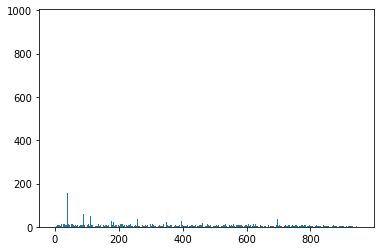

In [45]:
import seaborn as sns
plt.bar(x=range(len(x)),height=y)

In [47]:
import pandas as pd
import os
import glob
import email
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
import string
import re
import datetime as dt
from PIL import Image
from tqdm import tqdm
from string import digits
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
mails=pd.read_csv('/content/drive/MyDrive/Data_clean_processed.csv')
vocab=pd.read_csv('/content/drive/MyDrive/clean_vocab.csv')

In [49]:
all_docs=list(mails['bow'])
all_docs=all_docs[:5000]
all_mails=list(mails['email_id'])[:5000]
new_docs=[]
for item in all_docs:
  item=item.replace('aaa','')
  item=item.replace('imagemasker','')
  item=item.replace('urlmasker','')
  new_docs.append(item)
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

In [11]:
def word_gramma(a):
  res = []
  words = pos_tag(a)  
  for word, tag in words:
    if tag.startswith('NN') or tag.startswith('VB') or tag=='.':
      res.append(word)
  return ' '.join(res)

In [13]:
new_email = []
for email in tqdm(all_docs):
  a = word_tokenize(str(email).lower())
  new_email.append(word_gramma(a))

100%|██████████| 5000/5000 [00:20<00:00, 249.67it/s]


In [30]:
ops=pos_tag(word_tokenize(str(new_email[0]).lower()))

In [35]:
t=0
s=0
for i in range(len(all_docs)):
  s+=len(all_docs[i])
  t+=len(new_email[i])
print(s/t)

1.3666280112732807


In [36]:

all_docs=new_email

In [37]:
all_docs=list(mails['bow'])
all_docs=all_docs[:5000]
new_docs=[]
for item in all_docs:
  item=item.lower()
  item=item.replace('aaa','')
  item=item.replace('imagemasker','')
  item=item.replace('urlmasker','')
  new_docs.append(item)
stopset = stopwords.words('english') + list(string.punctuation) + ['will', 'also', 'said']

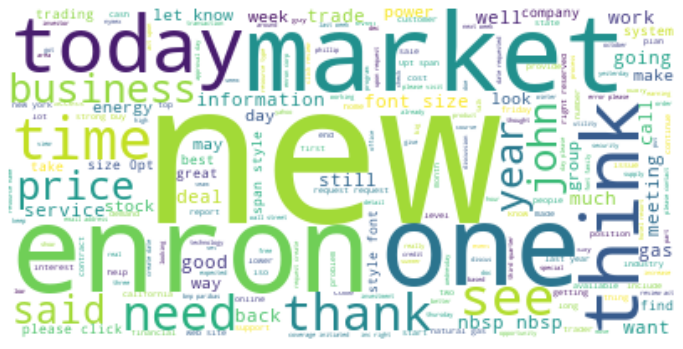

In [38]:
wordcloud = WordCloud(background_color='white').generate(' '.join(new_docs))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
%%time
from string import digits
corpus = []
all_docs = []
vocab = set()

stemmer = PorterStemmer()
for item in new_docs:
      try:
          remove_digits = str.maketrans('', '', digits)
          item = item.translate(remove_digits)
          all_docs.append(item)  
          tokens = word_tokenize(str(item))
          filtered = []
          for w in tokens:
              w = stemmer.stem(w.lower()) # use Porter's stemmer
              if len(w) < 3:              # remove short tokens
                  continue
              if w in stopset:            # remove stop words
                  continue
              filtered.append(w)
              
          vocab.update(filtered)
          corpus.append(filtered)      
          
      except UnicodeDecodeError:
          print('hel')

In [40]:
vocab = sorted(list(vocab))
vocab_index = {}
for i, w in enumerate(vocab):
    vocab_index[w] = i

In [41]:
new_corpus = []
for doc in corpus:
    new_doc = []
    for word in doc:
        word_idx = vocab_index[word]
        new_doc.append(word_idx)
    new_corpus.append(new_doc)

In [42]:
n_samples = 10      # no of iterations for the sampler
alpha = 10.0          # smoothing over level distributions
gamma = 1.0           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3       # the number of levels in the tree
display_topics = 5   # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights

In [43]:
hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling

..... 5
topic=0 level=0 (documents=5000): get, time, pleas, would, call, 
    topic=1 level=1 (documents=301): new, get, receiv, news, work, 
        topic=31 level=2 (documents=9): jeff, sign, onebox, drag, hotra, 
        topic=41 level=2 (documents=13): dkb, vbn, jdwatkiss, dwatkiss, patterson, 
        topic=45 level=2 (documents=24): toyota, camri, envoy, vehicl, autoweb, 
        topic=46 level=2 (documents=8): bmc, resid, bruce, jenni, smith, 
        topic=49 level=2 (documents=10): brain, oversea, xpit, thhere, thriti, 
        topic=50 level=2 (documents=3): sentenc, zurich, fit, fishman, fisher, 
        topic=53 level=2 (documents=15): incubu, music, download, win, imag, 
        topic=63 level=2 (documents=13): closur, euro, caiso, scan, make, 
        topic=72 level=2 (documents=10): vanderbilt, alumnu, univers, center, school, 
        topic=79 level=2 (documents=18): short, drink, huff, holst, juic, 
        topic=103 level=2 (documents=18): no

In [44]:
colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

def show_doc(d=0):
    
    node = hlda.document_leaves[d]
    path = []
    while node is not None:
        path.append(node)
        node = node.parent
    path.reverse()   
    
    n_words = 10
    with_weights = False    
    for n in range(len(path)):
        node = path[n]
        colour = colour_map[n] 
        msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
        msg += node.get_top_words(n_words, with_weights)
        output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
        display(HTML(output))
        
    display(HTML('<hr/><h5>Processed Document</h5>'))

    doc = corpus[d]
    output = ''
    for n in range(len(doc)):
        w = doc[n]
        l = hlda.levels[d][n]
        colour = colour_map[l]
        output += '<span style="color:%s">%s</span> ' % (colour, w)
    display(HTML(output))

In [45]:
widgets.interact(show_doc, d=(0, len(corpus)-1))

interactive(children=(IntSlider(value=0, description='d', max=4999), Output()), _dom_classes=('widget-interact…

<function __main__.show_doc(d=0)>

In [ ]:
p=str(hlda.document_leaves[20])
s=hlda.document_leaves[0]
all_mails[0]

In [1]:
import tomotopy
from tomotopy.utils import Corpus
crp=Corpus()
crp.add_doc(new_corpus)
# model=tomotopy.HLDAModel(depth=3)
# model.add_corpus(new_corpus)

NameError: ignored

In [14]:
mails=pd.read_csv('/content/drive/MyDrive/Data_clean_processed.csv')
vocab=pd.read_csv('/content/drive/MyDrive/clean_vocab.csv')

In [17]:
mails=mails.rename(columns={'email_id':'message_id'})
mails=mails.rename(columns={'bow':'clean_body'})

In [27]:
tmp=mails[['message_id','clean_body']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,message_id,clean_body,count
0,allen-p\all_documents\10#1,today copy bloomberg power line adobe acrobat ...,1325
1,allen-p\all_documents\100#1,initial set meeting trader regarding consolida...,344
2,allen-p\all_documents\101#1,initial set meeting trader regarding consolida...,344
3,allen-p\all_documents\108#1,think fletch good cpa still,4
4,allen-p\all_documents\11#1,sacramento correspondent exited news conferenc...,29
...,...,...,...
433012,zufferli-j\sent_items\93#1,good hear voice old buddy happy hear jessica b...,20
433013,zufferli-j\sent_items\94#1,thing little crazy today jess work thing last ...,27
433014,zufferli-j\sent_items\95#1,trade oil spec hedge john lavorato book john z...,37
433015,zufferli-j\sent_items\98#1,analyst rank stephane brodeur chad clark ian c...,11


In [39]:
# words_in = mails %>% dplyr::select(message_id, clean_body) %>%
#   unnest_tokens(word, clean_body) %>% filter(word %in% vocab$term, !word %like% "%aaa%",
#                                              !word %in% c("imagemasker", "urlmasker")) %>%# Vocab filter 
#   count(message_id, word) %>% cast_dfm(message_id, word, n)
tmp=mails[['message_id','clean_body']]
words=[]
for word in tqdm(vocab.term.unique()):
  if 'aaa' not in word and word!="imagemasker" and word!="urlmasker":
    words.append(word)
    tmp[word]=tmp['clean_body'].str.count(word)

  0%|          | 0/29999 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
  0%|          | 4/29999 [00:02<4:44:20,  1.76it/s]


KeyboardInterrupt: ignored

In [38]:
tmp = tmp.reset_index()
words_in=pd.melt(tmp, value_vars=words)

NameError: ignored